## Unzip Data

In [1]:
# !rm -r /content/splitted_images
# !rm -r /content/extracted_faces
# !rm -r /content/images
# !rm -r /content/__MACOSX

In [ ]:
# Unzip archive 

!unzip /content/drive/MyDrive/ki_project/images.zip -d /content
!rm -r /content/__MACOSX/

## Install and import packages

In [3]:
!pip install mtcnn
!pip install keras_vggface
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image
from os import listdir
from os.path import isfile, join
from shutil import copy2
import os

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

from mtcnn.mtcnn import MTCNN
from keras.models import load_model

from numpy import savez_compressed
from numpy import asarray
import numpy as np
from numpy import load
from numpy import expand_dims

img_base_path='/content/images/'
detector = MTCNN()

     |████████████████████████████████| 2.3 MB 6.7 MB/s 


## MTCNN test


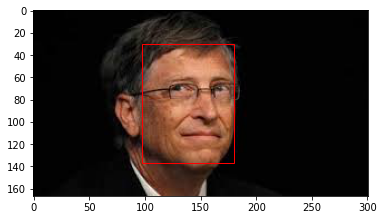

In [4]:
image = plt.imread(img_base_path + 'BillGates_358.jpg')

faces = detector.detect_faces(image)

def highlight_faces(image, faces):
  ax = plt.gca()
  # Draw a rectangle for each face
  for face in faces:
    x, y, width, height = face['box']
    face_border = Rectangle((x, y), width, height,
                          fill=False, color='red')
    ax.add_patch(face_border)
  plt.imshow(image)
  plt.show()
  

highlight_faces(image, faces)

## Extract faces and split images into train and test

In [8]:
def extract_face(filename):
  # Read image pixels
  rimage = plt.imread(filename)
	# Detect faces in the image
  faces = detector.detect_faces(rimage)
  if len(faces) > 0:
    # Get the coordinates of the biggest face
    x1, y1, width, height = faces[0]['box']
    # Fix bug 
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    # Save extraxted face to the variable
    extracted_face = rimage[y1:y2, x1:x2]
    # Resize image to required size
    image = Image.fromarray(extracted_face)
    image = image.resize((160, 160))
    return asarray(image)
  return None

In [15]:
!rm /content/images/.DS_Store

In [16]:
groups = {}
for file in listdir(img_base_path):
  group_name = file.split('_')[0]
  if group_name not in groups:
    groups[group_name] = {'count' : 0, 'items': []}
  groups[group_name]['count'] += 1
  groups[group_name]['items'].append(file)

if not os.path.exists('/content/extracted_faces'):
  os.mkdir('/content/extracted_faces')
if not os.path.exists('/content/extracted_faces/test'):
  os.mkdir('/content/extracted_faces/test')
if not os.path.exists('/content/extracted_faces/train'):
  os.mkdir('/content/extracted_faces/train')
  
for key, group in groups.items():
  copy_amount = round(group['count'] * 0.7)
  for file in group['items'][0:copy_amount]:
    if not isfile('/content/extracted_faces/train/' + file):
      face = extract_face(img_base_path + file)
      if face is not None:
        im = Image.fromarray(face)
        im.save('/content/extracted_faces/train/' + file)
  for file in group['items'][copy_amount:]:
    if not isfile('/content/extracted_faces/test/' + file):
      face = extract_face(img_base_path + file)
      if face is not None:
        im = Image.fromarray(face)
        im.save('/content/extracted_faces/test/' + file)





## Save faces and labels into a dataset

In [32]:
def prepare_dataset(directory):
  X, y = [], []
  for file in listdir(directory):
    path = directory + file
    label = file.split('_')[0]
    rimage = plt.imread(directory + file)
    y.append(label)
    X.append(rimage)
  out_encoder = LabelEncoder()
  out_encoder.fit(asarray(y))
  return asarray(X), out_encoder.transform(asarray(y))
 

In [33]:
# Save in trainX numpy array of images and in trainy of labels 
trainX, trainy = prepare_dataset('/content/extracted_faces/train/')
print('train set loaded')
testX, testy = prepare_dataset('/content/extracted_faces/test/')
print('test set loaded')
# Combine test and trainig data into one dataset
savez_compressed('/content/celebs_dataset.npz', trainX, trainy, testX, testy)

train set loaded
test set loaded
(2463, 160, 160, 3)
(2463,)
(1061, 160, 160, 3)
(1061,)


# Load dataset

In [34]:
# Load facenet model
model = load_model('/content/drive/MyDrive/ki_project/facenet_keras.h5')
data = load('/content/drive/MyDrive/ki_project/celebs_dataset.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']

[<KerasTensor: shape=(None, 160, 160, 3) dtype=float32 (created by layer 'input_1')>]


In [38]:
def get_embedding(model, face):
	face = face.astype('float32')
	# Normalize pixel values 
	mean, std = face.mean(), face.std()
	face = (face - mean) / std
	# Add another dimension since facenet model needs one dimension more than face has
	samples = expand_dims(face, axis=0)
	# Predict model to get embedding
	yhat = model.predict(samples)
	return yhat[0]

trainX_embeddings = []
for face in trainX:
	embedding = get_embedding(model, face)
	trainX_embeddings.append(embedding)
trainX_embeddings = asarray(trainX_embeddings)

testX_embeddings = []
for face in testX:
	embedding = get_embedding(model, face)
	testX_embeddings.append(embedding)
testX_embeddings = asarray(testX_embeddings)

# save embeddings to the file
savez_compressed('/content/celebs-embeddings.npz', trainX_embeddings, trainy, testX_embeddings, testy)

(2463, 128)
(2463,)
(1061, 128)
(1061,)


## Load embeddings dataset

In [39]:
data = load('/content/celebs-embeddings.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']


In [47]:
# Model 1
modelMLPC = MLPClassifier(hidden_layer_sizes=(128, 64, 32))
modelMLPC.fit(trainX, trainy)
# predict
yhat_trainMLPC = modelMLPC.predict(trainX)
yhat_testMLPC = modelMLPC.predict(testX)
# score
score_trainMLPC = accuracy_score(trainy, yhat_trainMLPC)
score_testMLPC = accuracy_score(testy, yhat_testMLPC)

# Model 2
modelRFR = RandomForestClassifier(n_estimators=100)
modelRFR.fit(trainX, trainy)
# predict
yhat_trainRFR = modelRFR.predict(trainX)
yhat_testRFR = modelRFR.predict(testX)
# score
score_trainRFR = accuracy_score(trainy, yhat_trainRFR)
score_testRFR = accuracy_score(testy, yhat_testRFR)

In [42]:

print('MLPC: ' + str(score_testMLPC))
print('RFR: ' + str(score_testRFR))

MLPC: 0.9792648444863337
RFR: 0.9754948162111216


## Grafiken

(0.0, 5.0)

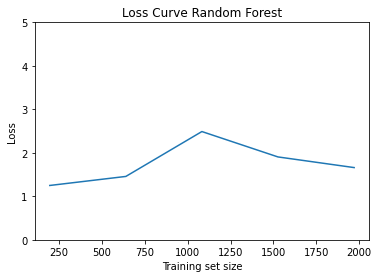

In [45]:
train_sizes, train_scores, validation_scores = learning_curve(estimator = RandomForestClassifier(n_estimators=100),X = trainX,y = trainy, cv = 5,scoring = 'neg_mean_squared_error',)

train_scores_mean = -train_scores.mean(axis = 0)
validation_scores_mean = -validation_scores.mean(axis = 0)
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('Loss')
plt.xlabel('Training set size')
plt.title('Loss Curve Random Forest')
plt.ylim(0,5)

In [46]:
train_sizes, train_scores, validation_scores = learning_curve(estimator = MLPClassifier(hidden_layer_sizes=(128, 64, 32)),X = trainX,y = trainy, cv = 5,scoring = 'neg_mean_squared_error')

train_scores_mean = -train_scores.mean(axis = 0)
validation_scores_mean = -validation_scores.mean(axis = 0)
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('Loss')
plt.xlabel('Training set size')
plt.title('Loss Curve MLPClassifier')
plt.ylim(0,5)

(0.0, 5.0)